## Gathering Dependencies

_Importing Required Libraries_

In [1]:
pip install hampel

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
from numpy import array

## Pretraining

_Lienard intermittancy_

The `lienard_intermittency.dat` feeds the model with the dynamics of the Lienard System

In [3]:
data = np.genfromtxt('datasets/lienard_intermittency.dat')
training_set = pd.DataFrame(data).reset_index(drop=True)
training_set = training_set.iloc[:,1]

## Computing the Gradients

_Calculating the value of_ $\frac{dx}{dt}$, _and_ $\frac{d^2x}{dt^2}$

In [4]:
t_diff = 7 # Weekly Data
print(training_set.max())
gradient_t = (training_set.diff()/t_diff).iloc[1:]
print(gradient_t)
gradient_tt = (gradient_t.diff()/t_diff).iloc[1:]
print(gradient_tt)

3.248363297340108
1        0.000042
2        0.000046
3        0.000047
4        0.000051
5        0.000055
           ...   
49995    0.000026
49996    0.000025
49997    0.000025
49998    0.000026
49999    0.000025
Name: 1, Length: 49999, dtype: float64
2        5.522854e-07
3        2.635995e-07
4        4.818741e-07
5        5.829681e-07
6        4.335565e-07
             ...     
49995   -6.136469e-09
49996   -1.012971e-07
49997    3.479342e-08
49998    8.847513e-08
49999   -7.587528e-08
Name: 1, Length: 49998, dtype: float64


## Loading Datasets

_SAN JUAN_

In [5]:
data = pd.read_csv("datasets/sanjuan.csv")
training_set = data.iloc[:, 3]
print(training_set)

0        4
1        5
2        4
3        3
4        6
        ..
1191    56
1192    46
1193    52
1194    34
1195    25
Name: Cases, Length: 1196, dtype: int64


In [6]:
training_set = training_set.reset_index(drop=True)
gradient_t = gradient_t.reset_index(drop=True)
gradient_tt = gradient_tt.reset_index(drop=True)
print(gradient_t)
print(gradient_tt)

0        0.000042
1        0.000046
2        0.000047
3        0.000051
4        0.000055
           ...   
49994    0.000026
49995    0.000025
49996    0.000025
49997    0.000026
49998    0.000025
Name: 1, Length: 49999, dtype: float64
0        5.522854e-07
1        2.635995e-07
2        4.818741e-07
3        5.829681e-07
4        4.335565e-07
             ...     
49993   -6.136469e-09
49994   -1.012971e-07
49995    3.479342e-08
49996    8.847513e-08
49997   -7.587528e-08
Name: 1, Length: 49998, dtype: float64


In [7]:
print(gradient_t.shape)
print(training_set.shape[:-1])
df = pd.concat((training_set[:-1], gradient_t), axis=1)
gradient_tt.columns = ["grad_tt"]
df = pd.concat((df[:-1], gradient_tt), axis=1)
df.columns = ['y_t', 'grad_t', 'grad_tt']

(49999,)
()


## Plot of the External Forcing from Chaotic Differential Equation (_Lienard Systems_)

<AxesSubplot:>

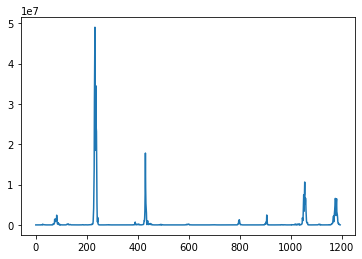

In [8]:
a = 0.45
b = 0.5 #1.0
c = -0.5 #-1.68
L = df.iloc[:,2] + a*df.iloc[:,0]*df.iloc[:,1] +c*df.iloc[:,0] +b* df.iloc[:,0]**3
L.plot()

## Preprocessing the data into supervised learning

In [9]:
def Supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
       agg.dropna(inplace=True)
    return agg    

In [10]:
dat = Supervised(df.values, n_in = 10, n_out = 13)
dat.columns

Index(['var1(t-10)', 'var2(t-10)', 'var3(t-10)', 'var1(t-9)', 'var2(t-9)',
       'var3(t-9)', 'var1(t-8)', 'var2(t-8)', 'var3(t-8)', 'var1(t-7)',
       'var2(t-7)', 'var3(t-7)', 'var1(t-6)', 'var2(t-6)', 'var3(t-6)',
       'var1(t-5)', 'var2(t-5)', 'var3(t-5)', 'var1(t-4)', 'var2(t-4)',
       'var3(t-4)', 'var1(t-3)', 'var2(t-3)', 'var3(t-3)', 'var1(t-2)',
       'var2(t-2)', 'var3(t-2)', 'var1(t-1)', 'var2(t-1)', 'var3(t-1)',
       'var1(t)', 'var2(t)', 'var3(t)', 'var1(t+1)', 'var2(t+1)', 'var3(t+1)',
       'var1(t+2)', 'var2(t+2)', 'var3(t+2)', 'var1(t+3)', 'var2(t+3)',
       'var3(t+3)', 'var1(t+4)', 'var2(t+4)', 'var3(t+4)', 'var1(t+5)',
       'var2(t+5)', 'var3(t+5)', 'var1(t+6)', 'var2(t+6)', 'var3(t+6)',
       'var1(t+7)', 'var2(t+7)', 'var3(t+7)', 'var1(t+8)', 'var2(t+8)',
       'var3(t+8)', 'var1(t+9)', 'var2(t+9)', 'var3(t+9)', 'var1(t+10)',
       'var2(t+10)', 'var3(t+10)', 'var1(t+11)', 'var2(t+11)', 'var3(t+11)',
       'var1(t+12)', 'var2(t+12)', 'var3(t+12)']

In [11]:
data = Supervised(df.values, n_in = 10, n_out = 13)
data.drop(['var2(t-10)', 'var3(t-10)', 'var2(t-9)', 'var3(t-9)', 'var2(t-8)',
       'var3(t-8)', 'var2(t-7)', 'var3(t-7)', 'var2(t-6)', 'var3(t-6)',
       'var2(t-5)', 'var3(t-5)', 'var2(t-4)', 'var3(t-4)', 'var2(t-2)',
       'var3(t-2)', 'var2(t-1)', 'var3(t-1)','var2(t-3)', 'var3(t-3)'], axis = 1, inplace = True)#,18,19
print(data.head())
print(data.columns)

    var1(t-10)  var1(t-9)  var1(t-8)  var1(t-7)  var1(t-6)  var1(t-5)  \
10         4.0        5.0        4.0        3.0        6.0        2.0   
11         5.0        4.0        3.0        6.0        2.0        4.0   
12         4.0        3.0        6.0        2.0        4.0        5.0   
13         3.0        6.0        2.0        4.0        5.0       10.0   
14         6.0        2.0        4.0        5.0       10.0        6.0   

    var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  ...  var3(t+9)  var1(t+10)  \
10        4.0        5.0       10.0        6.0  ...   0.000017        40.0   
11        5.0       10.0        6.0        8.0  ...   0.000025        27.0   
12       10.0        6.0        8.0        2.0  ...   0.000040        42.0   
13        6.0        8.0        2.0        6.0  ...   0.000070        33.0   
14        8.0        2.0        6.0       17.0  ...   0.000136        43.0   

    var2(t+10)  var3(t+10)  var1(t+11)  var2(t+11)  var3(t+11)  var1(t+12)  \
10    0.000511

## Train and Test Split

In [12]:
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train_1 = np.array(data[0:train_size])
test_1 = np.array(data[train_size:len(data)])
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train_1)
test = scaler.transform(test_1)
trainY = train[:,-9:]
trainX = train[:,:-9]
testY = test[:,-9:]
testX = test[:,:-9]
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(938, 1, 40) (938, 9) (235, 1, 40) (235, 9)


## Defining the Physical Loss

In [13]:
a = tf.Variable(0.45, name="a", trainable=True, dtype=tf.float32)
b = tf.Variable(0.5, name="b", trainable=True, dtype=tf.float32)
c = tf.Variable(-0.5, name="c", trainable=True, dtype=tf.float32)
def phys(y_pred, y_true):
    return mean_absolute_error(y_true[:,2] + a*y_true[:,0]*y_true[:,1] +c*y_true[:,0] +b* y_true[:,0]**3, y_pred[:,2] + a*y_pred[:,0]*y_pred[:,1] +c*y_pred[:,0] +b* y_pred[:,0]**3)
def phys2(y_pred, y_real):
    pred = y_pred[2:]-2*y_pred[1:-1]-y_pred[:-2] +a*y_pred[:-2]*(y_pred[1:-1]-y_pred[:-2]) +c*y_pred[:-2] +b* y_pred[:-2]**3
    real = y_real[2:]-2*y_real[1:-1]-y_real[:-2] +a*y_real[:-2]*(y_real[1:-1]-y_real[:-2]) +c*y_real[:-2] +b* y_real[:-2]**3
    return(mean_absolute_error(pred,real))

## Model (Without Monte Carlo Dropout)

In [14]:
a = tf.Variable(0.45, name="a", trainable=True, dtype=tf.float32)
b = tf.Variable(0.5, name="b", trainable=True, dtype=tf.float32)
c = tf.Variable(-0.5, name="c", trainable=True, dtype=tf.float32)
def loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true[:,0] - y_pred[:,0])
    squared_difference2 = tf.square(y_true[:,2]-y_pred[:,2])
    squared_difference1 = tf.square(y_true[:,1]-y_pred[:,1])    
    squared_difference3 = tf.square(y_pred[:,2] + a*y_pred[:,0]*y_pred[:,1] +c*y_pred[:,0] +b* y_pred[:,0]**3)
    return tf.reduce_mean(squared_difference, axis=-1) + 0.2*tf.reduce_mean(squared_difference3, axis=-1)
model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(9))
model.compile(loss=loss_fn, optimizer='adam')
history = model.fit(trainX[:int(0.8*trainX.shape[0])], trainY[:int(0.8*trainX.shape[0])], epochs=500, batch_size=64, validation_data=(trainX[int(0.8*trainX.shape[0]):trainX.shape[0]], trainY[int(0.8*trainX.shape[0]):trainX.shape[0]]), shuffle=False)

Epoch 1/500
12/12 [==============================] - 3s 47ms/step - loss: 0.0203 - val_loss: 0.0083
Epoch 2/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0118 - val_loss: 0.0047
Epoch 3/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0109 - val_loss: 0.0049
Epoch 4/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0087 - val_loss: 0.0039
Epoch 5/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0079 - val_loss: 0.0037
Epoch 6/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0067 - val_loss: 0.0032
Epoch 7/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0061 - val_loss: 0.0030
Epoch 8/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0054 - val_loss: 0.0028
Epoch 9/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0026
Epoch 10/500
12/12 [==============================] - 0s 4ms/step - loss: 0.0045 - val_loss: 0.0024
Epoch 11

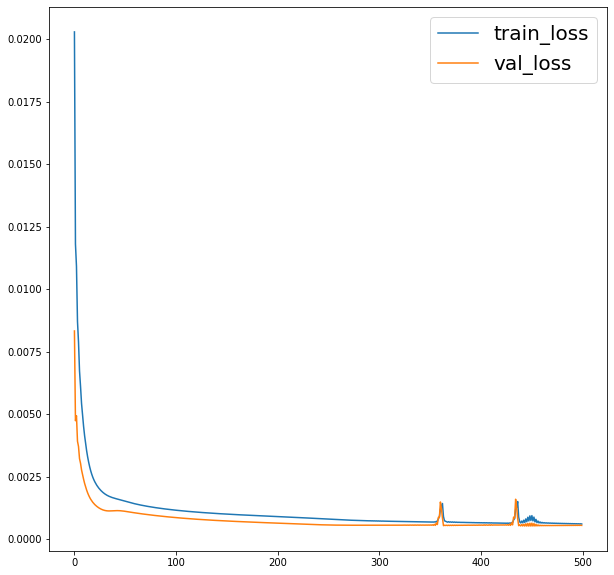

In [15]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(fontsize=20)
plt.show()

## Metrics (Without Monte Carlo Dropout)

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
textX_without_mc = testX
textY_without_mc = testY
yhat_without_mc = model.predict(textX_without_mc)
print(yhat_without_mc.shape)
textX_without_mc = textX_without_mc.reshape((textX_without_mc.shape[0], textX_without_mc.shape[2]))
print(textX_without_mc.shape)
inv_yhat_without_mc = np.concatenate((textX_without_mc, yhat_without_mc), axis=1)
inv_yhat_without_mc = scaler.inverse_transform(inv_yhat_without_mc)
inv_yhat1_without_mc = inv_yhat_without_mc[:, -3:]
inv_yhat_without_mc = inv_yhat_without_mc[:, -3]
inv_y_without_mc = np.concatenate((textX_without_mc, textY_without_mc), axis=1)
inv_y_without_mc = scaler.inverse_transform(inv_y_without_mc)
inv_y1_without_mc = inv_y_without_mc[:, -3:]
inv_y_without_mc = inv_y_without_mc[:, -3]
rmse_without_mc = np.sqrt(mean_squared_error(inv_y_without_mc, inv_yhat_without_mc))
mae_without_mc = mean_absolute_error(inv_y_without_mc, inv_yhat_without_mc)
print('Test RMSE: %.3f' % rmse_without_mc)
print('Test MAE: %.3f' % mae_without_mc)

8/8 [==============================] - 1s 4ms/step
(235, 9)
(235, 40)
Test RMSE: 67.045
Test MAE: 52.249


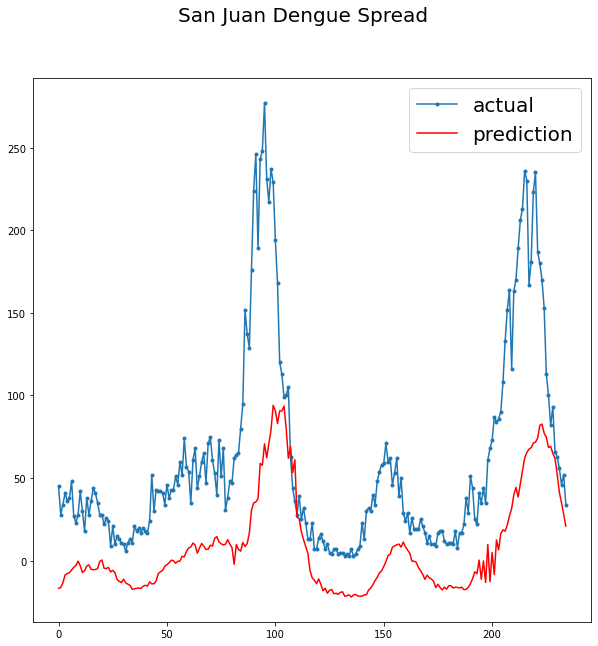

In [17]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(inv_y_without_mc, marker='.', label="actual")
plt.plot(inv_yhat_without_mc, 'r', label="prediction")
plt.suptitle('San Juan Dengue Spread', fontsize=20)
plt.legend(fontsize=20)
plt.show()

## Model (With Monte Carlo Dropout)

In [18]:
class MCDropout(Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [19]:
a = tf.Variable(0.45, name="a", trainable=True, dtype=tf.float32)
b = tf.Variable(0.5, name="b", trainable=True, dtype=tf.float32)
c = tf.Variable(-0.5, name="c", trainable=True, dtype=tf.float32)
def loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true[:,0] - y_pred[:,0])
    squared_difference2 = tf.square(y_true[:,2]-y_pred[:,2])
    squared_difference1 = tf.square(y_true[:,1]-y_pred[:,1])    
    squared_difference3 = tf.square(y_pred[:,2] + a*y_pred[:,0]*y_pred[:,1] +c*y_pred[:,0] +b* y_pred[:,0]**3)
    return tf.reduce_mean(squared_difference, axis=-1) + 0.2*tf.reduce_mean(squared_difference3, axis=-1)
model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(9))
model.add(MCDropout(0.4))
model.compile(loss=loss_fn, optimizer='adam')
history = model.fit(trainX[:int(0.8*trainX.shape[0])], trainY[:int(0.8*trainX.shape[0])], epochs=500, batch_size=64, validation_data=(trainX[int(0.8*trainX.shape[0]):trainX.shape[0]], trainY[int(0.8*trainX.shape[0]):trainX.shape[0]]), shuffle=False)

Epoch 1/500
12/12 [==============================] - 20s 73ms/step - loss: 0.0192 - val_loss: 0.0074
Epoch 2/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0153 - val_loss: 0.0066
Epoch 3/500
12/12 [==============================] - 0s 5ms/step - loss: 0.0145 - val_loss: 0.0051
Epoch 4/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0118 - val_loss: 0.0050
Epoch 5/500
12/12 [==============================] - 0s 5ms/step - loss: 0.0128 - val_loss: 0.0049
Epoch 6/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0042
Epoch 7/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0041
Epoch 8/500
12/12 [==============================] - 0s 5ms/step - loss: 0.0092 - val_loss: 0.0033
Epoch 9/500
12/12 [==============================] - 0s 5ms/step - loss: 0.0097 - val_loss: 0.0039
Epoch 10/500
12/12 [==============================] - 0s 6ms/step - loss: 0.0101 - val_loss: 0.0055
Epoch 1

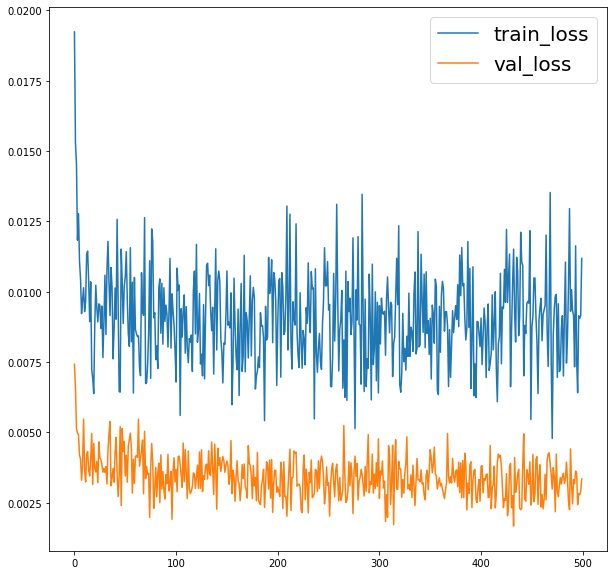

In [20]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(fontsize=20)
plt.show()

## Metrics (With Monte Carlo Dropout)

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
textX_with_mc = testX
textY_with_mc = testY
yhat_with_mc = model.predict(textX_with_mc)
print(yhat_with_mc.shape)
textX_with_mc = testX.reshape((textX_with_mc.shape[0], textX_with_mc.shape[2]))
print(textX_with_mc.shape)
inv_yhat_with_mc = np.concatenate((textX_with_mc, yhat_with_mc), axis=1)
inv_yhat_with_mc = scaler.inverse_transform(inv_yhat_with_mc)
inv_yhat1_with_mc = inv_yhat_with_mc[:, -3:]
inv_yhat_with_mc = inv_yhat_with_mc[:, -3]
inv_y_with_mc = np.concatenate((textX_with_mc, textY_with_mc), axis=1)
inv_y_with_mc = scaler.inverse_transform(inv_y_with_mc)
inv_y1_with_mc = inv_y_with_mc[:, -3:]
inv_y_with_mc = inv_y_with_mc[:, -3]
rmse_with_mc = np.sqrt(mean_squared_error(inv_y_with_mc, inv_yhat_with_mc))
mae_with_mc = mean_absolute_error(inv_y_with_mc, inv_yhat_with_mc)
print('Test RMSE: %.3f' % rmse_with_mc)
print('Test MAE: %.3f' % mae_with_mc)

8/8 [==============================] - 1s 1ms/step
(235, 9)
(235, 40)
Test RMSE: 65.037
Test MAE: 44.052


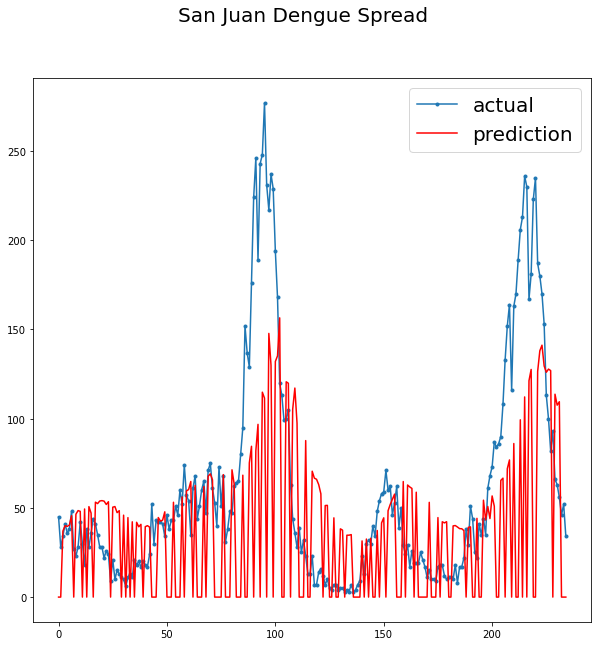

In [22]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(inv_y_with_mc, marker='.', label="actual")
plt.plot(inv_yhat_with_mc, 'r', label="prediction")
plt.suptitle('San Juan Dengue Spread', fontsize=20)
plt.legend(fontsize=20)
plt.show()